<a href="https://colab.research.google.com/github/Veraeze/AmineRegeneration/blob/main/ReboilerDuty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Step 1: Load Dataset from Google Drive & Install Dependencies

In this step, we will:

- Install essential Python libraries required for this project:
  - `pandas` for data manipulation
  - `scikit-learn` for machine learning models
  - `matplotlib` and `seaborn` for visualizations
  - `xgboost` for gradient boosting regression
- Mount Google Drive to access the dataset
- Load the dataset (`amine_gen_data.csv`) into a Pandas DataFrame

These steps prepare the environment for model training and analysis.

In [5]:
# Install required libraries

!pip install pandas scikit-learn matplotlib seaborn xgboost

In [6]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Load the dataset, skipping the first two non-data rows

import pandas as pd

file_path = '/content/drive/MyDrive/MLDatasets/amine_gen_data.csv'
df = pd.read_csv(file_path, skiprows=[1, 2])

# Display first few rows
df.head()

,State,stripper - Spec Value (Duty),stripper - Stage Pressure (Condenser),stripper - Stage Pressure (Reboiler),DEA6 - Temperature,DEA6 - CO2 Composition(mole %),DEA6 - H2S Composition(ppm),DEA6 - Molar Flow,DEA6 - Acid Gas Temperature,DEA7 - Temperature,DEA7 - CO2 Composition(mole %),DEA7 - H2S Composition(ppm),DEA7 - Molar Flow
0,Case 1,10900000.0,20.3,23.3,210,0.03972,171.7,4193,210,268.3,0.02120,107.2,4192
1,Case 2,10900000.0,20.3,23.3,210,0.03972,171.7,4193,210,268.3,0.02141,103.4,4192
2,Case 3,10900000.0,20.3,23.3,210,0.03972,171.7,4193,210,268.3,0.02149,106.6,4192
3,Case 4,10900000.0,20.3,23.3,210,0.03972,171.7,4193,210,268.3,0.02149,104.1,4192
4,Case 5,10900000.0,20.3,23.3,210,0.03972,171.7,4193,210,268.3,0.02145,106.6,4192


#  Step 2: Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand its structure, quality, and the relationships between variables.

The key goals are:
- Check for missing or inconsistent data
- Review feature distributions and units
- Understand correlations between input features and the target (`Reboiler Duty`)
- Identify potential outliers or patterns

This step helps us understand the dataset before applying machine learning models.

In [10]:
# Show basic structure and column types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49915 entries, 0 to 49914
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   State                                  49915 non-null  object 
 1   stripper - Spec Value (Duty)           49915 non-null  float64
 2   stripper - Stage Pressure (Condenser)  49915 non-null  float64
 3   stripper - Stage Pressure (Reboiler)   49915 non-null  float64
 4   DEA6 - Temperature                     49915 non-null  int64  
 5   DEA6 - CO2 Composition(mole %)         49915 non-null  float64
 6   DEA6 - H2S Composition(ppm)            49915 non-null  float64
 7   DEA6 - Molar Flow                      49915 non-null  int64  
 8   DEA6 - Acid Gas Temperature            49915 non-null  int64  
 9   DEA7 - Temperature                     49915 non-null  float64
 10  DEA7 - CO2 Composition(mole %)         49915 non-null  float64
 11  DE

The output above summarizes the structure of our dataset:

- **Total entries:** 49,915 rows
- **Total columns:** 13 features (including both input variables and target values)
- **Data types:** The dataset contains numerical data (`float64` and `int64`) with one object-type column (`Unnamed: 0`), which may be an index or case label.
- **Missing Values:** No null values were found, which is good for direct model training.

We **kept the first row** as column headers because it contains the actual feature names. We **skipped the second and third rows** because:
  - The second row is empty and not useful.
  - The third row contains only units (e.g., "psig", "Btu/hr"), which are not appropriate as column names.


In [11]:
# Show summary stats for numerical columns

df.describe()

,stripper - Spec Value (Duty),stripper - Stage Pressure (Condenser),stripper - Stage Pressure (Reboiler),DEA6 - Temperature,DEA6 - CO2 Composition(mole %),DEA6 - H2S Composition(ppm),DEA6 - Molar Flow,DEA6 - Acid Gas Temperature,DEA7 - Temperature,DEA7 - CO2 Composition(mole %),DEA7 - H2S Composition(ppm),DEA7 - Molar Flow
count,4.991500e+04,49915.000000,49915.000000,49915.000000,4.991500e+04,4.991500e+04,49915.0,49915.000000,49915.000000,49915.000000,49915.000000,49915.000000
mean,1.591737e+07,20.304055,23.304055,210.015026,3.972000e-02,1.717000e+02,4193.0,210.015026,268.305716,0.016057,84.315394,4191.240188
std,2.877422e+06,0.234584,0.234584,0.946740,1.069294e-14,1.128922e-10,0.0,0.946740,0.326383,0.002608,10.133323,0.427202
min,1.090000e+07,19.000000,22.000000,200.000000,3.972000e-02,1.717000e+02,4193.0,200.000000,266.200000,0.012290,69.610000,4191.000000
25%,1.340000e+07,20.300000,23.300000,210.000000,3.972000e-02,1.717000e+02,4193.0,210.000000,268.300000,0.013760,75.420000,4191.000000
50%,1.590000e+07,20.300000,23.300000,210.000000,3.972000e-02,1.717000e+02,4193.0,210.000000,268.300000,0.015660,82.840000,4191.000000
75%,1.840000e+07,20.300000,23.300000,210.000000,3.972000e-02,1.717000e+02,4193.0,210.000000,268.300000,0.018140,92.460000,4191.000000
max,2.090000e+07,40.000000,43.000000,295.000000,3.972000e-02,1.717000e+02,4193.0,295.000000,294.700000,0.021530,107.200000,4192.000000


The table above provides descriptive statistics for each numerical feature in the dataset:

- Several features such as `DEA6 - CO2 Composition` and `DEA6 - H2S Composition` show very **low variability**, which suggests constant or nearly constant values across all cases.
- The **target variable**, `stripper - Spec Value (Duty)`, ranges from approximately **10.9 million to 20.9 million Btu/hr**, with a mean of **~15.9 million Btu/hr**.
- Features like `DEA6 - Temperature`, `DEA7 - Temperature`, and `stripper pressures` have small variations around fixed operating set points (e.g., most `DEA6` values cluster around 210°F).
- The **standard deviation for some features is zero**, such as `DEA6 - Molar Flow`, indicating these values are constant and may not contribute to model learning. These may be considered for **removal** or **dimensionality reduction** later.

This step gives us insights into feature variability, which helps guide preprocessing and feature selection.

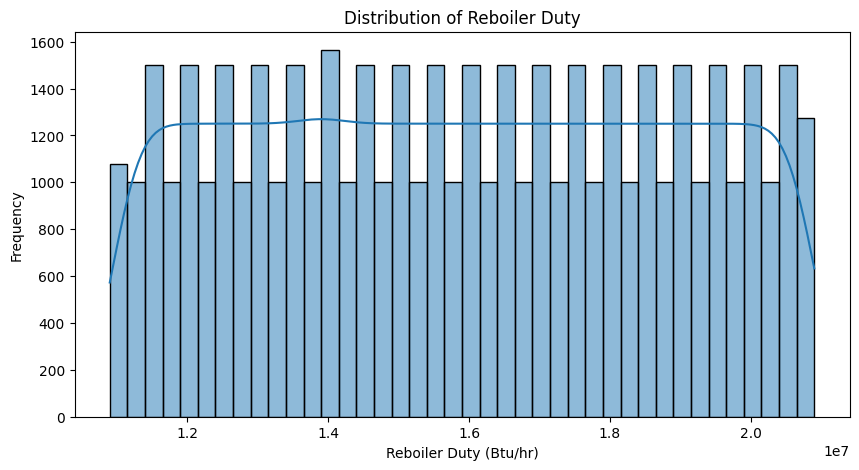

In [13]:
# Reboiler duty distribution plot

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df['stripper - Spec Value (Duty)'], bins=40, kde=True)
plt.title('Distribution of Reboiler Duty')
plt.xlabel('Reboiler Duty (Btu/hr)')
plt.ylabel('Frequency')
plt.show()

The histogram above shows a relatively **uniform distribution** of reboiler duty values ranging from approximately **11 million to 21 million Btu/hr**.

Key observations:
- The values are evenly spread across the range, suggesting that the simulation dataset was systematically varied.
- There is **no strong skewness**, and the shape is roughly flat, indicating no dominant peak or clustering.
- **No major outliers** are observed, which means the data is likely clean and well-prepared for regression modeling.
- Since there's no obvious optimal zone in the distribution, a machine learning model will be essential to **identify energy-efficient reboiler duty values** based on input conditions.

This confirms that the target variable is suitable for predictive modeling using regression techniques.